In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

## No movement

### Read data
#### Read the csv files and plot them

In [3]:
def read_data_csv(filename):
    data = pd.read_csv(f"data/{filename}",sep=";")
    data.index = data["Phone timestamp"]
    data =data.drop(columns=["Phone timestamp","sensor timestamp [ns]"])
    data.index = pd.to_datetime(data.index)
    return data

In [4]:
def plot_with_markers(data,markers):
    fig, ax = plt.subplots(figsize=(15,7))
    for col in data.columns:
        ax.plot(data[col],label=col)
    for i,(start,end) in enumerate(markers):
        ax.axvspan(start,end,color='r',alpha=0.2,label="Marker" if i == 0 else "")
    
    ax.legend()
    plt.show()

In [5]:
data_passe_avant = read_data_csv("Passe_avant.csv")
markers_passe_avant = [
    (data_passe_avant.index[20],data_passe_avant.index[60]),
    (data_passe_avant.index[150],data_passe_avant.index[200]),
    (data_passe_avant.index[275],data_passe_avant.index[325]),
    (data_passe_avant.index[500],data_passe_avant.index[540]),
    (data_passe_avant.index[650],data_passe_avant.index[690]),
    (data_passe_avant.index[850],data_passe_avant.index[890]),
]

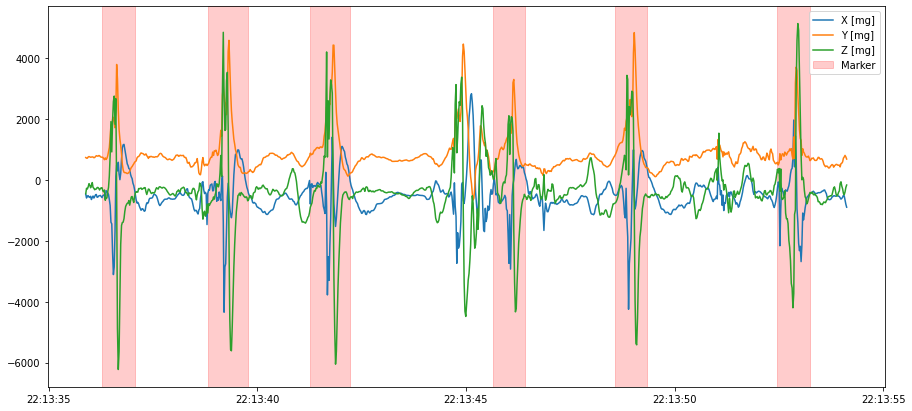

In [6]:
plot_with_markers(data_passe_avant,markers_passe_avant)

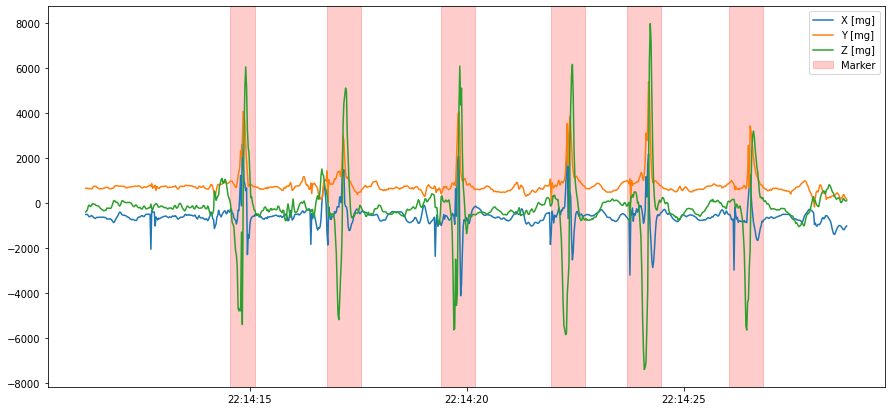

In [7]:
data_passe_backend = read_data_csv("Passe_backend.csv")
markers_passe_backend = [
    (data_passe_backend.index[170],data_passe_backend.index[200]),
    (data_passe_backend.index[285],data_passe_backend.index[325]),
    (data_passe_backend.index[420],data_passe_backend.index[460]),
    (data_passe_backend.index[550],data_passe_backend.index[590]),
    (data_passe_backend.index[640],data_passe_backend.index[680]),
    (data_passe_backend.index[760],data_passe_backend.index[800]),
]
plot_with_markers(data_passe_backend,markers_passe_backend)

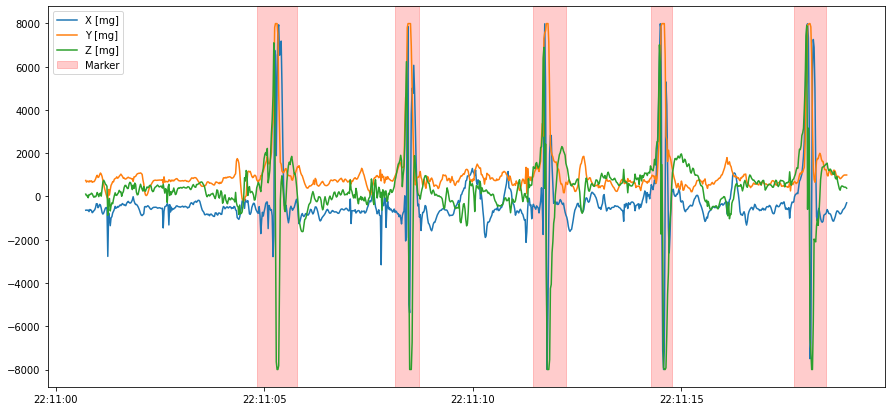

In [8]:
data_tir_avant = read_data_csv("Tir_avant.csv")
markers_tir_avant = [
    (data_tir_avant.index[210],data_tir_avant.index[260]),
    (data_tir_avant.index[380],data_tir_avant.index[410]),
    (data_tir_avant.index[550],data_tir_avant.index[590]),
    (data_tir_avant.index[695],data_tir_avant.index[720]),
    (data_tir_avant.index[870],data_tir_avant.index[910]),
]
plot_with_markers(data_tir_avant,markers_tir_avant)

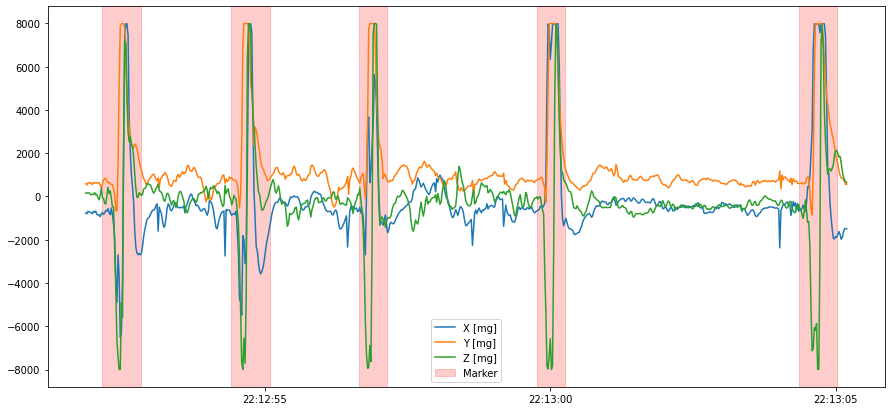

In [9]:
data_tir_backend = read_data_csv("Tir_backend.csv")
markers_tir_backend = [
    (data_tir_backend.index[15],data_tir_backend.index[50]),
    (data_tir_backend.index[130],data_tir_backend.index[165]),
    (data_tir_backend.index[245],data_tir_backend.index[270]),
    (data_tir_backend.index[405],data_tir_backend.index[430]),
    (data_tir_backend.index[640],data_tir_backend.index[-10]),
]
plot_with_markers(data_tir_backend,markers_tir_backend)

In [10]:
def add_column_classification(data,markers):
    y = np.zeros(len(data))
    for (start,end,label) in markers:
        y[np.argwhere((data.index > start) & (data.index < end))] = label
    return y

In [11]:
def concatenate_data(data_tir,data_passe,markers_tir,markers_passe):
    first_pass_timestamp = data_passe.index[0]
    last_shoot_timestamp = data_tir.index[-1]

    data_passe.index -= first_pass_timestamp
    data_passe.index += last_shoot_timestamp
    data = pd.concat((data_tir,data_passe))
    markers = []
    
    for (start,end) in markers_tir:
        markers.append((start,end,1))

    for (start,end) in markers_passe:
        start -= first_pass_timestamp
        start += last_shoot_timestamp
        end -= first_pass_timestamp
        end += last_shoot_timestamp
        markers.append((start,end,2))

    return data, markers

In [12]:
def concatenate_data_bis(data1,data2,markers1,markers2):
    first_timestamp = data2.index[0]
    last_timestamp = data1.index[-1]

    data2.index -= first_timestamp
    data2.index += last_timestamp
    data = pd.concat((data1,data2))

    markers = markers1.copy()

    for (start,end,label) in markers2:
        start -= first_timestamp
        start += last_timestamp
        end -= first_timestamp
        end += last_timestamp
        markers.append((start,end,label))

    return data, markers

In [13]:
def plot_with_markers_label(data,markers):
    fig, ax = plt.subplots(figsize=(15,7))
    for col in data.columns:
        ax.plot(data[col],label=col)
    for i,(start,end,label) in enumerate(markers):
        ax.axvspan(start,end,color='r'if label==1 else 'g',alpha=0.2)
    
    ax.legend()
    plt.show()

In [14]:
data_backend,markers_backend = concatenate_data(data_tir_backend.copy(),data_passe_backend.copy(),markers_tir_backend,markers_passe_backend)
data_avant,markers_avant = concatenate_data(data_tir_avant.copy(),data_passe_avant.copy(),markers_tir_avant,markers_passe_avant)

In [15]:
#data,markers = concatenate_data(data_tir_backend.copy(),data_passe_backend.copy(),markers_tir_backend,markers_passe_backend)
#plot_with_markers_label(data,markers)

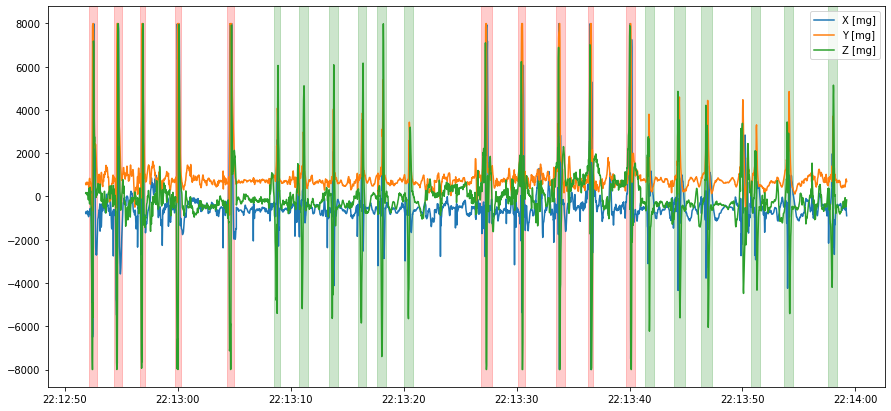

In [16]:
data,markers = concatenate_data_bis(data_backend.copy(),data_avant.copy(),markers_backend,markers_avant)
plot_with_markers_label(data,markers)

In [17]:
y_real = add_column_classification(data,markers)
y_real.shape

(3456,)

In [18]:
freq_sampling = 50

In [19]:
def compute_features(block):
    norms = np.linalg.norm(block,axis=1)
    return np.array([np.abs(np.max(norms)-np.min(norms)),np.max(norms),np.quantile(norms,0.25)])

In [20]:
def get_label(y):
    uniques,counts = np.unique(y,return_counts=True)
    return uniques[np.argmax(counts)]
    

In [21]:
def window_slide(data:pd.DataFrame,y,window_size):
    dataset = data.values
    n = len(data)//window_size
    features_extracted = []
    y_block = np.zeros(n)
    for i in range(n):
        block = dataset[i*window_size:(i+1)*window_size]
        features = compute_features(block)
        features_extracted.append(features)
        y_block[i] = get_label(y[i*window_size:(i+1)*window_size])
    return np.array(features_extracted),y_block

In [22]:
def box_plot(data,y,window_size,labels=['idk','shoot','pass']):
    dataset = data.values
    n = len(data)//window_size
    features_extracted = []
    blocks = {u:[] for u in np.unique(y)}
    for i in range(n):
        block = dataset[i*window_size:(i+1)*window_size]
        blocks[y[i]].append(block)
    
    data_box = []
    for label in blocks.keys():
        norms = []
        for block in blocks[label]:
            norms.append(np.linalg.norm(block,axis=1))
        
        norms = np.concatenate(norms)
        data_box.append(norms)

    fig,ax = plt.subplots(figsize=(10,7))
    ax.boxplot(data_box)
    ax.set_xticks(np.arange(1,len(blocks.keys())+1))
    ax.set_xticklabels(labels)
    plt.show()

In [23]:
markers_timedelta_max=np.max([end-start for (start,end,_) in markers])//(1.8)
window_size=int(markers_timedelta_max.total_seconds()*freq_sampling)
window_size

27

In [24]:
def plot_data_y(data,y,window_size):
    fig,ax = plt.subplots(figsize=(15,7))
    ax.plot(data.values)
    for i in range(len(y)):
        if y[i]!=0:
            ax.axvspan(i*window_size,(i+1)*window_size,color='r'if y[i]==1 else 'g',alpha=0.2)
    

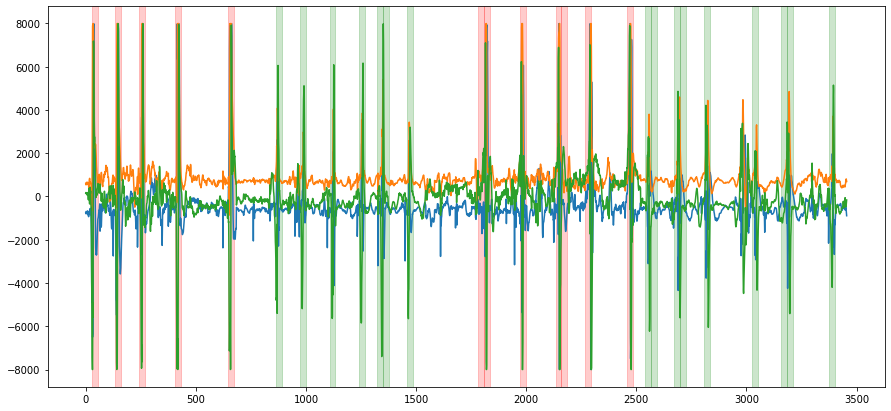

In [25]:
X,y = window_slide(data,y_real,window_size)
y.shape
plot_data_y(data,y,window_size)

In [26]:
def add_samples_shoot_pass(X,y,n,add_noise=True):
    idx_shoot = np.argwhere(y==1)
    idx_pass = np.argwhere(y==2)

    idx_shoot = np.repeat(idx_shoot,n)
    idx_pass = np.repeat(idx_pass,n)

    idx_shoot = idx_shoot[np.random.choice(idx_shoot.shape[0],n,replace=False)]
    idx_pass = idx_pass[np.random.choice(idx_pass.shape[0],n,replace=False)]

    new_X = np.zeros((X.shape[0]+2*n,X.shape[1]))
    new_y = np.zeros(X.shape[0]+2*n)

    new_X[:X.shape[0],:] = X[:,:].copy()
    new_y[:X.shape[0]] = y[:].copy()

    new_X[X.shape[0]:X.shape[0]+n,:] = X[idx_shoot,:] + np.random.normal(10,100,size=[n,X.shape[1]]) if add_noise else 0.
    new_X[X.shape[0]+n:,:] = X[idx_pass,:]  + np.random.normal(10,100,size=[n,X.shape[1]]) if add_noise else 0.

    new_y[X.shape[0]:X.shape[0]+n] = 1
    new_y[X.shape[0]+n:] = 2

    return new_X, new_y
        

In [27]:
X,y = add_samples_shoot_pass(X,y,n=15,add_noise=True)

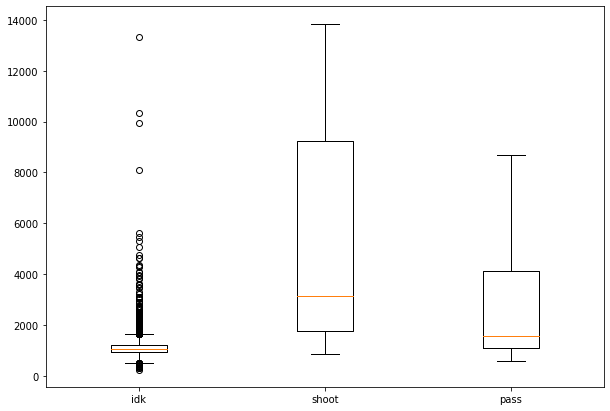

In [28]:
box_plot(data,y,window_size)

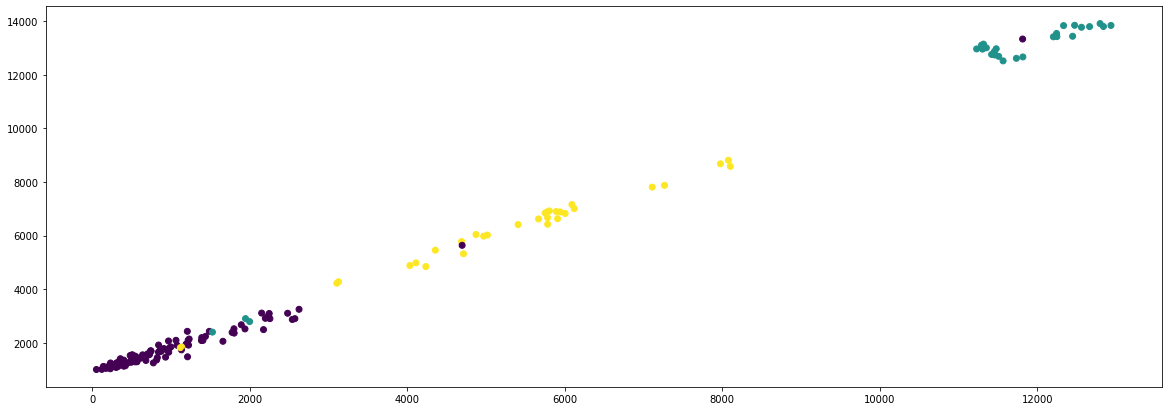

In [29]:
# Quick plot to see if we can separate the data for machine learning 
fig,ax = plt.subplots(figsize=(20,7))
ax.scatter(X[:,0],X[:,1],c=y)
plt.show()

In [30]:
%matplotlib qt

fig = plt.figure(figsize=(20,7))
ax = fig.add_subplot(projection='3d')

ax.scatter(X[:,0],X[:,1],X[:,2],c=y)

plt.show()

In [31]:
%matplotlib inline

## Classifiers

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sn
from sklearn import metrics

In [33]:
X.shape

(158, 3)

In [34]:
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.33)

### Logistic Regression

In [35]:
clf = LogisticRegression()
clf.fit(X_train,y_train)

c:\DEV\QSelf\venv\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

<AxesSubplot:>

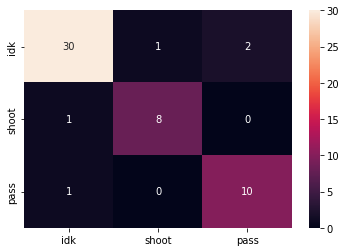

In [36]:
labels = ['idk','shoot','pass']
y_pred_test=clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred_test)
sn.heatmap(cm, annot=True,xticklabels=labels,yticklabels=labels)

In [37]:
print(f'Accuracy with test data : {metrics.accuracy_score(y_test, y_pred_test)}')

Accuracy with test data : 0.9056603773584906


<AxesSubplot:>

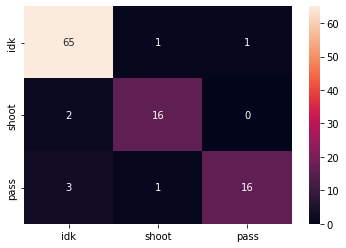

In [38]:
y_pred_train=clf.predict(X_train)
cm = confusion_matrix(y_train, y_pred_train)
sn.heatmap(cm, annot=True,xticklabels=labels,yticklabels=labels)

In [39]:
print(f'Accuracy with train data : {metrics.accuracy_score(y_train, y_pred_train)}')

Accuracy with train data : 0.9238095238095239


### KNN

In [41]:
clf = KNeighborsClassifier()
clf.fit(X_train,y_train)

KNeighborsClassifier()

<AxesSubplot:>

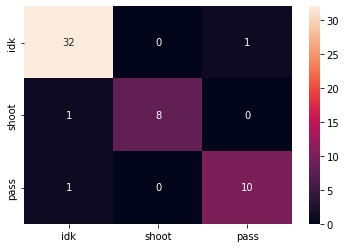

In [42]:
y_pred_test=clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred_test)
sn.heatmap(cm, annot=True,xticklabels=labels,yticklabels=labels)

In [43]:
print(f'Accuracy with test data : {metrics.accuracy_score(y_test, y_pred_test)}')

Accuracy with test data : 0.9433962264150944


<AxesSubplot:>

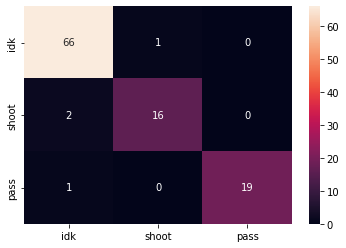

In [44]:
y_pred_train=clf.predict(X_train)
cm = confusion_matrix(y_train, y_pred_train)
sn.heatmap(cm, annot=True,xticklabels=labels,yticklabels=labels)

In [45]:
print(f'Accuracy with train data : {metrics.accuracy_score(y_train, y_pred_train)}')

Accuracy with train data : 0.9619047619047619


## Data with movement

In [49]:
def read_markers(filename):
    df_markers = pd.read_csv(f'data/{filename}', sep=';', header=0, names=['timestamp', 'mark'], index_col=0, parse_dates=True)
    markers = []
    for i in range(0,len(df_markers)-1,2):
        markers.append((df_markers.index[i],df_markers.index[i+1]))
    return markers

In [54]:
data_shoot_moving = read_data_csv('DATA_NEW/SHOOT_AVANT.csv')
markers_shoot_moving = read_markers('DATA_NEW/MARKER_SHOOT_AVANT.csv')
markers_shoot_moving

[(Timestamp('2021-12-07 21:17:35.555000'),
  Timestamp('2021-12-07 21:17:37.555000')),
 (Timestamp('2021-12-07 21:17:40.554000'),
  Timestamp('2021-12-07 21:17:43.295000')),
 (Timestamp('2021-12-07 21:17:46.991000'),
  Timestamp('2021-12-07 21:17:49.383000')),
 (Timestamp('2021-12-07 21:17:52.615000'),
  Timestamp('2021-12-07 21:17:55.086000')),
 (Timestamp('2021-12-07 21:17:57.496000'),
  Timestamp('2021-12-07 21:17:59.900000')),
 (Timestamp('2021-12-07 21:18:06.125000'),
  Timestamp('2021-12-07 21:18:09.940000')),
 (Timestamp('2021-12-07 21:18:11.790000'),
  Timestamp('2021-12-07 21:18:16.822000')),
 (Timestamp('2021-12-07 21:18:17.493000'),
  Timestamp('2021-12-07 21:18:21.538000')),
 (Timestamp('2021-12-07 21:18:27.044000'),
  Timestamp('2021-12-07 21:18:29.480000')),
 (Timestamp('2021-12-07 21:18:35.591000'),
  Timestamp('2021-12-07 21:18:38.148000')),
 (Timestamp('2021-12-07 21:18:40.107000'),
  Timestamp('2021-12-07 21:18:42.393000'))]

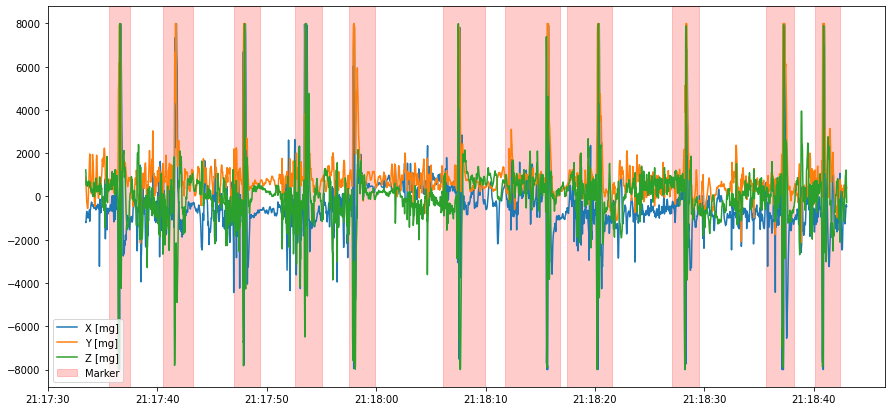

In [55]:
plot_with_markers(data_shoot_moving,markers_shoot_moving)

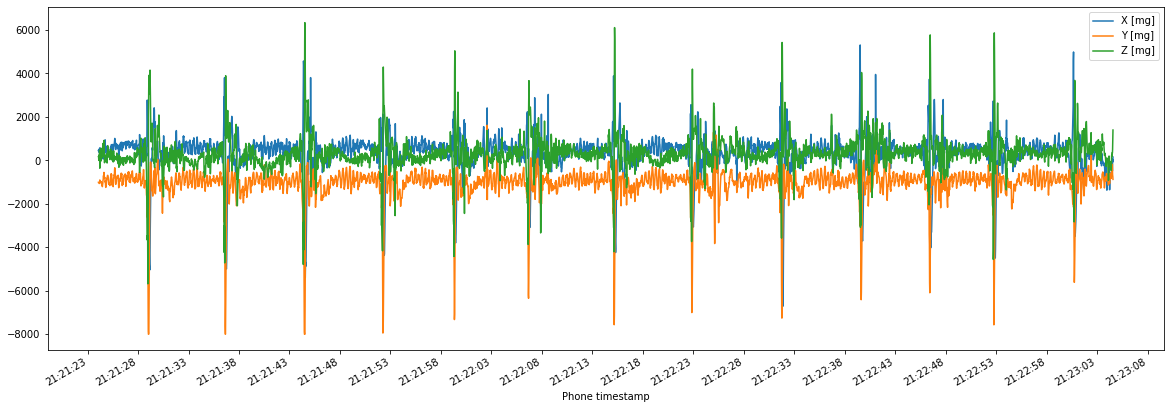

In [61]:
data_pass_moving = read_data_csv('DATA_NEW/PASSE_AVANT_THOMAS.csv')
ax = data_pass_moving.plot(figsize=(20,7))
ax.xaxis.set_major_locator(mdates.SecondLocator(interval=5))
plt.show()

In [63]:
markers_pass_moving = read_markers('DATA_NEW/MARKER_PASS_AVANT.csv')

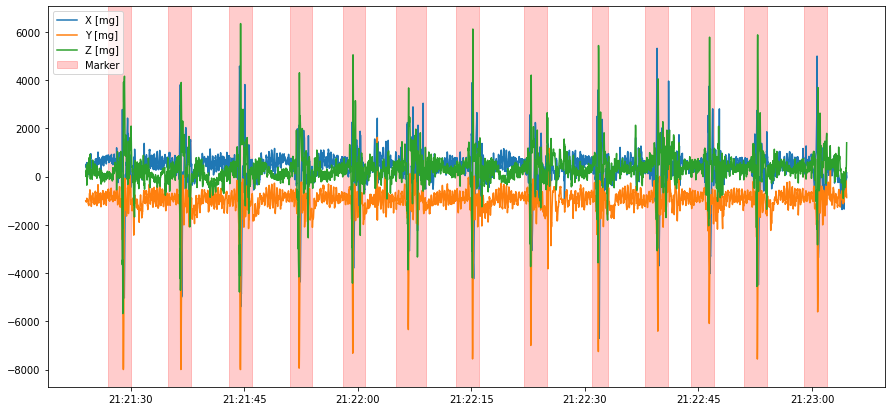

In [64]:
plot_with_markers(data_pass_moving,markers_pass_moving)

In [72]:
data_moving,markers_moving = data_backend,markers_backend = concatenate_data(data_shoot_moving.copy(),data_pass_moving.copy(),markers_shoot_moving,markers_pass_moving)

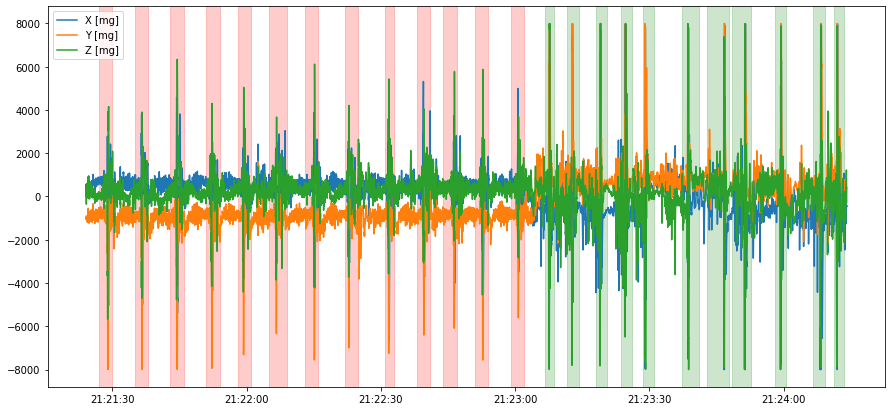

In [73]:
plot_with_markers_label(data_moving,markers_moving)

In [74]:
y_real_moving = add_column_classification(data_moving,markers_moving)
y_real_moving.shape

(8712,)

In [82]:
markers_timedelta_max=np.max([end-start for (start,end,_) in markers_moving])//(1.8)
window_size=int(markers_timedelta_max.total_seconds()*freq_sampling)
window_size

139

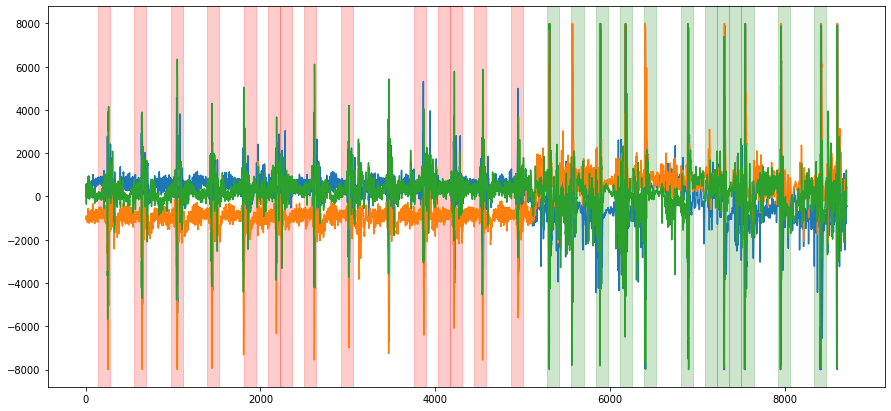

In [88]:
X,y = window_slide(data_moving,y_real_moving,window_size)
plot_data_y(data_moving,y,window_size)

In [89]:
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.45)

[Logistic Regression] Accuracy with train data : 0.7352941176470589
[Logistic Regression] Accuracy with test data : 0.8571428571428571
[Logistic Regression] Number of shoots detected : 8
[Logistic Regression] Number of passes detected : 10


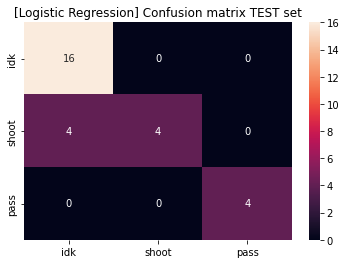

In [93]:
# Logistic Regression
clf = LogisticRegression()
clf.fit(X_train,y_train)

y_pred_train=clf.predict(X_train)
y_pred_test=clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred_test)

ax = plt.axes()
sn.heatmap(cm, annot=True,xticklabels=labels,yticklabels=labels,ax=ax)
ax.set_title('[Logistic Regression] Confusion matrix TEST set')

print(f'[Logistic Regression] Accuracy with train data : {metrics.accuracy_score(y_train, y_pred_train)}')
print(f'[Logistic Regression] Accuracy with test data : {metrics.accuracy_score(y_test, y_pred_test)}')

n_shoot_detected = len(y_pred_train[y_pred_train==1])+len(y_pred_test[y_pred_test==1])
n_pass_detected = len(y_pred_train[y_pred_train==2])+len(y_pred_test[y_pred_test==2])
print(f'[Logistic Regression] Number of shoots detected : {n_shoot_detected}')
print(f'[Logistic Regression] Number of passes detected : {n_pass_detected}')

[KNeighbors Classifier] Accuracy with train data : 0.8235294117647058
[KNeighbors Classifier] Accuracy with test data : 0.9285714285714286
[Logistic Regression] Number of shoots detected : 13
[Logistic Regression] Number of passes detected : 12


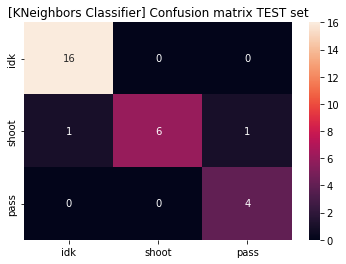

In [94]:
# KNeighbors Classifier
clf = KNeighborsClassifier()
clf.fit(X_train,y_train)

y_pred_train=clf.predict(X_train)
y_pred_test=clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred_test)

ax = plt.axes()
sn.heatmap(cm, annot=True,xticklabels=labels,yticklabels=labels,ax=ax)
ax.set_title('[KNeighbors Classifier] Confusion matrix TEST set')

print(f'[KNeighbors Classifier] Accuracy with train data : {metrics.accuracy_score(y_train, y_pred_train)}')
print(f'[KNeighbors Classifier] Accuracy with test data : {metrics.accuracy_score(y_test, y_pred_test)}')

n_shoot_detected = len(y_pred_train[y_pred_train==1])+len(y_pred_test[y_pred_test==1])
n_pass_detected = len(y_pred_train[y_pred_train==2])+len(y_pred_test[y_pred_test==2])
print(f'[KNeighbors Classifier] Number of shoots detected : {n_shoot_detected}')
print(f'[KNeighbors Classifier] Number of passes detected : {n_pass_detected}')